# STA 208: Homework 2
This is based on the material in Chapters 3, 4.4 of 'Elements of Statistical Learning' (ESL), in addition to lectures 4-6.  Chunzhe Zhang came up with the dataset and the analysis in the second section.

## Instructions

We use a script that extracts your answers by looking for cells in between the cells containing the exercise statements (beginning with __Exercise X.X__).  So you 

- MUST add cells in between the exercise statements and add answers within them and
- MUST NOT modify the existing cells, particularly not the problem statement

To make markdown, please switch the cell type to markdown (from code) - you can hit 'm' when you are in command mode - and use the markdown language.  For a brief tutorial see: https://daringfireball.net/projects/markdown/syntax

In the conceptual exercises you should provide an explanation, with math when necessary, for any answers.  When answering with math you should use basic LaTeX, as in 
$$E(Y|X=x) = \int_{\mathcal{Y}} f_{Y|X}(y|x) dy = \int_{\mathcal{Y}} \frac{f_{Y,X}(y,x)}{f_{X}(x)} dy$$
for displayed equations, and $R_{i,j} = 2^{-|i-j|}$ for inline equations.  (To see the contents of this cell in markdown, double click on it or hit Enter in escape mode.)  To see a list of latex math symbols see here: http://web.ift.uib.no/Teori/KURS/WRK/TeX/symALL.html

# 1. Conceptual Exercises

__Exercise 1.1.__ (5 pts) Ex. 3.29 in ESL 

We will assume that X is centered.  The intercept is
$$\bar y =  \arg \min_{\beta_0} \| y - \beta_0 - X \beta \|_2^2 + \lambda \| \beta \|_2^2$$
and 
$$\hat \beta = \arg \min_\beta \| (y - \bar y) - X \beta \|_2^2 + \lambda \| \beta \|_2^2$$
satisfies the Ridge normal equations:
$$(X^\top X + \lambda I) \hat \beta = X^\top y$$
Furthermore, $X^\top y$ has identical values in each coordinate, call it $x^\top y$.  Also, $X^\top X$ has the same value $\|x\|_2^2$ throughout.
The solution for a single $x$ is $\hat \beta = x^\top y / (\| x \|_2^2 + \lambda)$.
Let's guess that by symmetry $$\hat \beta_j = \frac{1}{p\|x\|_2^2 + \lambda} x^\top y, \quad \forall j$$.
Then we see that $(X^\top X + \lambda I)_k \hat \beta = \| x \|_2^2 \sum_j \hat \beta_j  + \lambda \hat \beta_k = (p \| x \|_2^2 + \lambda) \hat \beta_k = x^\top y$.
Check!


__Exercise 1.2__ (5 pts) Ex. 3.30 in ESL
Consider the elastic net,
$$\min_\beta \| y - X \beta \|_2^2 + \lambda (\alpha \|\beta \|_2^2 + (1 - \alpha) \|\beta\|_1)$$
Let's try to absorb the $\ell_2$ penalty into the loss function.
$$y^\top y - 2 y^\top X \beta + \beta^\top X^\top X \beta + \lambda \alpha \beta^\top \beta$$
which is (up to a constant addition)
$$\beta^\top (X^\top X + \lambda \alpha I) \beta - 2 y^\top X \beta.$$
So we can re-write the objective as
$$\min_\beta \beta^\top (X^\top X + \lambda \alpha I) \beta - 2 y^\top X \beta + \lambda (1 - \alpha) \|\beta\|_1$$
which is a lasso problem.

__Exercise 1.3__ (5 pts) $Y \in \{0,1\}$ follows an exponential family model with natural parameter $\eta$ if
$$P(Y=y) = \exp\left( y \eta - \psi(\eta) \right).$$
Show that when $\eta = x^\top \beta$ then $Y$ follows a logistic regression model.

$$P(Y=1) + P(Y=0) = (1 + \exp(\eta)) \exp(- \psi (\eta)) = 1$$
So $\psi(\eta) = \log(1 + \exp(\eta))$, then one could recognize 
$$P(Y=y) = \exp \left(y x^\top \beta + \log (1 + \exp(x^\top \beta))\right)$$
as the logistic model.  Or see that
$$\log \frac{P(Y=1)}{P(Y=0)} = \eta = x^\top \beta.$$

# 2. Data Analysis

In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, lars_path, LogisticRegression
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline
# dataset path
data_dir = "."

Load the following medical dataset with 750 patients. The response variable is survival dates (Y), the predictors are 104 measurements measured at a specific time (numerical variables have been standardized).

In [11]:
sample_data = pd.read_csv(data_dir+"/hw2.csv", delimiter=',')

In [12]:
sample_data.head()

,Y,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104
0,1498,No,0.171838,-0.081764,-1.448868,-1.302547,-0.143061,-0.339784,-1.206475,0.444493,...,-1.379066,0.420436,-0.827446,0.318695,-0.787409,0.351406,-0.836107,0.015502,0.435444,-0.879906
1,334,Yes,-0.605767,-0.584360,-0.485169,-0.848111,-0.493546,-0.392332,-0.239788,0.421697,...,0.398840,-0.434789,-0.698862,1.387219,0.948456,0.191397,1.451699,-1.243616,-0.699072,1.751434
2,845,Yes,-0.266330,-0.126965,0.138401,0.262732,-0.202438,0.397194,0.137790,0.047847,...,-0.450999,-0.627830,0.677158,-0.140255,-0.798641,-0.972419,-0.852035,0.080914,-1.906252,0.705509
3,1484,No,0.113498,0.893293,-0.825298,-0.444168,0.756242,0.179122,-1.145078,-1.471261,...,0.316312,0.131010,0.878134,-0.306249,-1.263270,1.316120,-0.999717,1.104161,-0.234038,-0.083488
4,301,Yes,-0.620454,-0.608036,-0.088352,0.111253,-0.598898,-0.513191,0.753000,1.055418,...,0.364884,0.251667,0.373787,-0.354599,0.085019,1.207509,-0.762206,-0.067318,0.158247,0.592638


In [13]:
sample_data.V1 = sample_data.V1.eq('Yes').mul(1)

The response variable is Y. 

In [14]:
X = np.array(sample_data.iloc[:,range(2,104)])
y = np.array(sample_data.iloc[:,0])
z = np.array(sample_data.iloc[:,1])

__Exercise 2.1__ (10 pts) Perform ridge regression on the method and cross-validate to find the best ridge parameter.

In [35]:
X = scale(X)

In [36]:
alphas = 2.**np.arange(20) / 2.**10
ridgecv = RidgeCV(alphas=alphas, cv=None, store_cv_values=True)
ridgecv.fit(X,y)

RidgeCV(alphas=array([  9.76562e-04,   1.95312e-03,   3.90625e-03,   7.81250e-03,
         1.56250e-02,   3.12500e-02,   6.25000e-02,   1.25000e-01,
         2.50000e-01,   5.00000e-01,   1.00000e+00,   2.00000e+00,
         4.00000e+00,   8.00000e+00,   1.60000e+01,   3.20000e+01,
         6.40000e+01,   1.28000e+02,   2.56000e+02,   5.12000e+02]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=True)

0.0009765625


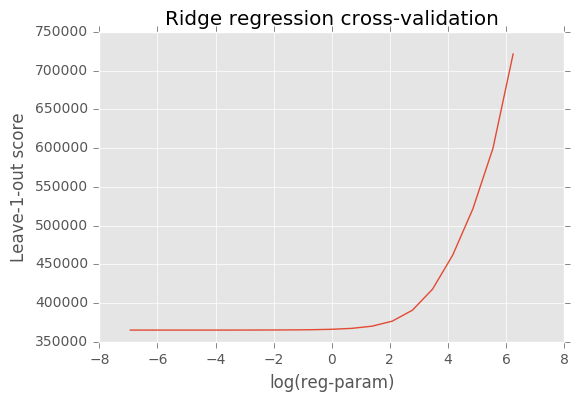

In [41]:
print(ridgecv.alpha_)
plt.plot(np.log(alphas),ridgecv.cv_values_.mean(axis=0))
plt.xlabel('log(reg-param)')
plt.ylabel('Leave-1-out score')
_ = plt.title('Ridge regression cross-validation')

In [100]:
np.min(ridgecv.cv_values_.mean(axis=0))

365304.88182289281

The natural conclusion is that ridge regularization does not improve the performance based on leave-one-out classification.

__Exercise 2.2__ (10 pts) Plot the lasso and lars path for each of the coefficients.  All coefficients for a given method should be on the same plot, you should get 2 plots.  What are the major differences, if any?  Are there any 'leaving' events in the lasso path?

In [58]:
def plot_lars(coefs, lines=False, title="Lars Path"):
    xx = np.sum(np.abs(coefs.T), axis=1)
    xx /= xx[-1]
    plt.plot(xx, coefs.T)
    ymin, ymax = plt.ylim()
    if lines:
        plt.vlines(xx, ymin, ymax, linestyle='dashed')
    plt.xlabel('|coef| / max|coef|')
    plt.ylabel('Coefficients')
    plt.title(title)
    plt.axis('tight')

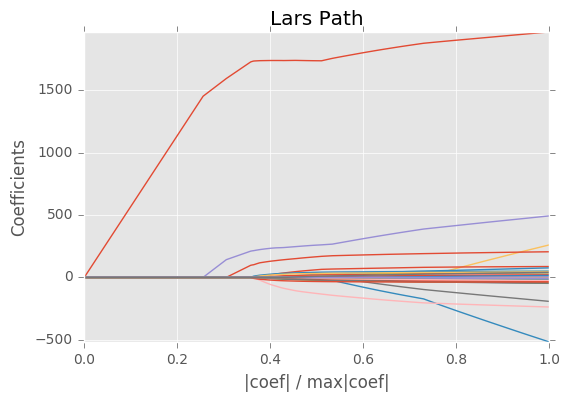

In [57]:
alphas_lars, _, coefs_lars = lars_path(X,y)
plot_lars(coefs_lars)

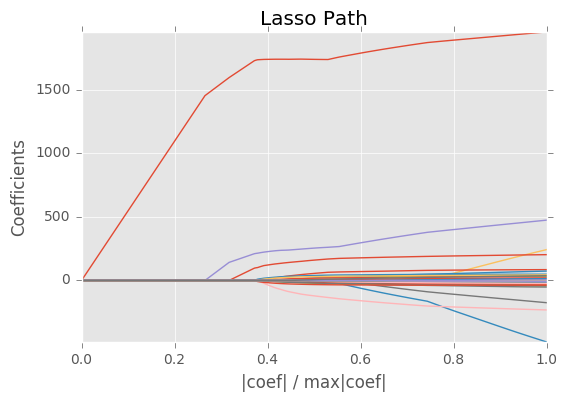

In [60]:
alphas_lasso, _, coefs_lasso = lars_path(X,y,method='lasso')
plot_lars(coefs_lasso,title="Lasso Path")

The Lars and Lasso paths look identical, which is due to the lack of any leaving events.  Recall that leaving events were the lasso modification to the lars path.

__Exercise 2.3__ (10 pts) Cross-validate the Lasso and compare the results to the answer to 2.1.

In [111]:
lassocv = LassoCV(cv=None)
lassocv.fit(X,y)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [113]:
alpha = lassocv.alpha_

In [114]:
cv_scores = lassocv.mse_path_.mean(axis=1)

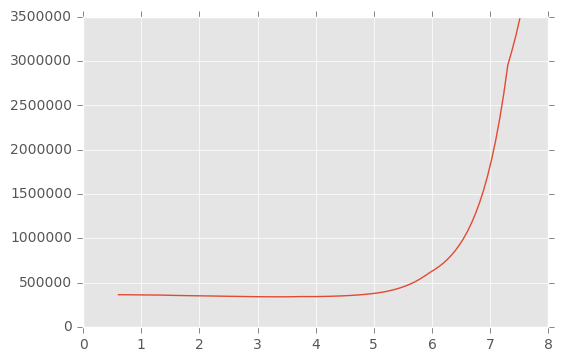

In [115]:
_ = plt.plot(np.log(lassocv.alphas_),cv_scores)

In [117]:
np.min(cv_scores)

339606.79721941613

The optimal cross-validated score for the Lasso is 3.4e6 and that for ridge regression is 3.65e6.  Hence, the lasso outperforms ridge regression and OLS.

__Exercise 2.4__ (15 pts) Obtain the 'best' active set from 2.3, and create a new design matrix with only these variables.  Use this to predict the categorical variable $z$ with logistic regression. 

In [120]:
Xred = X[:,lassocv.coef_ > 0.0]

In [124]:
lr = LogisticRegression(C=99.)

In [125]:
lr.fit(Xred,z)

LogisticRegression(C=99.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [128]:
zhat = lr.predict(Xred)

In [129]:
confusion_matrix(z,zhat)

array([[149,  57],
       [ 27, 517]])

The number confusion matrix above describes the performance of the logistic regression over the reduced dataset.